In [ ]:
pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 8.1 MB/s 


In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import os
import phik

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from prettytable import PrettyTable
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [ ]:
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [ ]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [ ]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [ ]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

In [ ]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

In [ ]:
import gdown
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Basic Overview**

In [ ]:
credit_card_balance = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/credit_card_balance.csv'))
print('Number of data points : ', credit_card_balance.shape[0])
print('Number of features : ', credit_card_balance.shape[1])
credit_card_balance.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Number of data points :  3840312
Number of features :  23


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [ ]:
application_test = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/application_test.csv'))
print('Number of data points : ', test_data.shape[0])
print('Number of features : ', test_data.shape[1])
test_data.head()

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Number of data points :  48744
Number of features :  121


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
application_train = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/application_train.csv'))
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
train_data.head()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Number of data points :  307511
Number of features :  122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f'The shape of credit_card_balance.csv is: {credit_card_balance.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Number of duplicate values in credit_card_balance: {credit_card_balance.shape[0] - credit_card_balance.duplicated().shape[0]}')
print('-'*100)
display(credit_card_balance.head(5))

The shape of credit_card_balance.csv is: (3840312, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


**Comment** 
1.   There are around 3.84M rows in the table credit_card_balance.csv, each of which corresponds to the monthly status of the Credit Card which the applicant had with Home Credit Group. This table contains 23 features which contain the statistics about each month's Credit Card status, such as Balance amount, Amount of Drawings, Number of drawings, status, etc.
2.   There are 104.3k unique Credit Cards whose details are in this table.
3. Out of these 104.3k there are 103.5k unique SK_ID_CURR. What this means is that most of the applicants had just 1 credit card with them, and only few of them had more than 1. These SK_ID_CURR are the ID of the applicants who have currently applied for loan.
4. Out of the 103k unique SK_ID_CURR, 86.9k of these applicants belong to the training set, and 16.6k belong to test application set.
5. Out of 307k applicants in application_train table, only 86.9k of those had a credit card previously with Home Credit Group.







### **NaN Columns and Percentages**

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


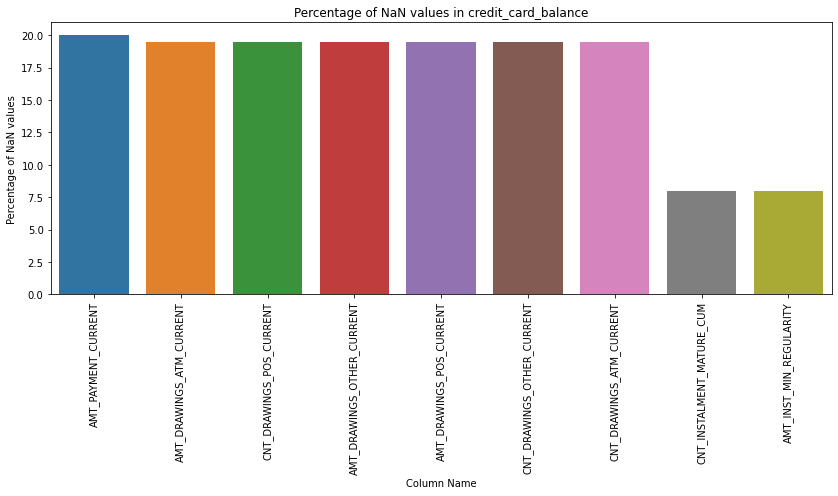

----------------------------------------------------------------------------------------------------


In [ ]:
credit_card_balance_nan = nan_df_create(credit_card_balance)
print('-'*100)
plot_nan_percent(credit_card_balance_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)
del credit_card_balance_nan

**Comment**
1.   Out of the 23 features, 9 of these features contain some NaN values.
2.   If we look at the percentages of NaN values, they are considerably lower than the rest of the tables we have seen so far.
3. 7 of these features have close to 20% NaN values. These features are mostly related to the Amounts of Drawing and Counts of Drawings. Other two of the features are related to the installments statistics.



**Merging the TARGETS from application_train to credit_card_balance table.**

In [ ]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
credit_card_balance_merged = application_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


**Correlation Matrix of Features**

----------------------------------------------------------------------------------------------------


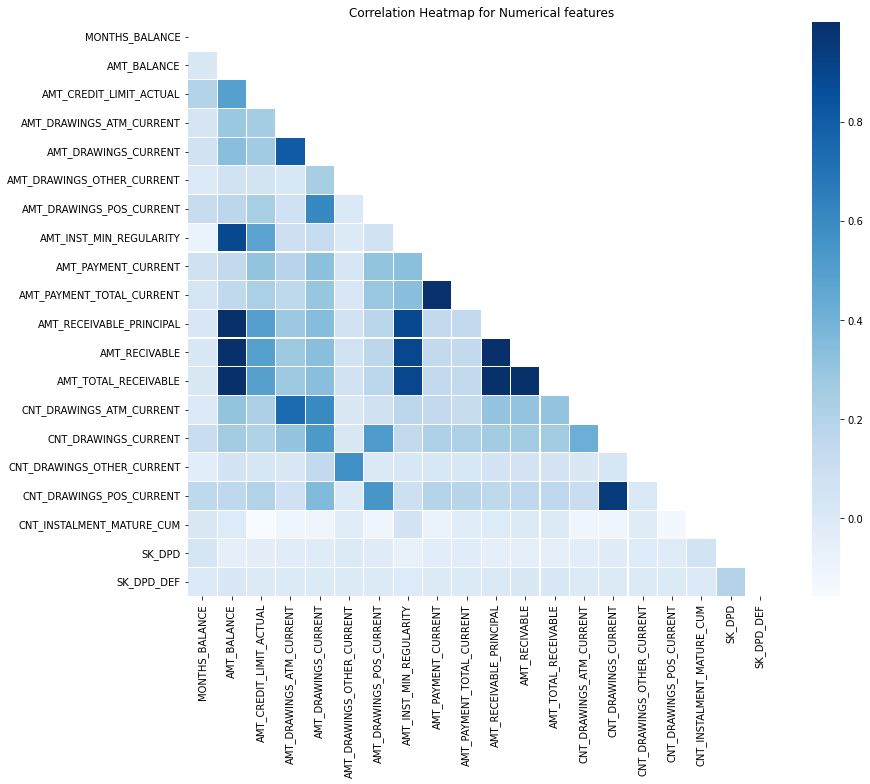

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(credit_card_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [ ]:
#Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

,Column Name,Phik-Correlation
1,AMT_BALANCE,0.059838
11,AMT_RECIVABLE,0.059311
12,AMT_TOTAL_RECEIVABLE,0.059287
10,AMT_RECEIVABLE_PRINCIPAL,0.058895
0,MONTHS_BALANCE,0.050360
7,AMT_INST_MIN_REGULARITY,0.042174
17,CNT_INSTALMENT_MATURE_CUM,0.038261
13,CNT_DRAWINGS_ATM_CURRENT,0.030052
2,AMT_CREDIT_LIMIT_ACTUAL,0.028752
14,CNT_DRAWINGS_CURRENT,0.027868


----------------------------------------------------------------------------------------------------


**Comment**
1.   The heatmap above shows visually the correlation among features in credit_card_balance table.
2.   From the heatmap of correlation matrix, we see a few couples of highly correlated features. These are:
 *   AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE and AMT_BALANCE
 *   We also observe high correlation between these 3 AMT_RECEIVABLE columns
 *   AMT_PAYMENT_TOTAL_CURRENT and AMT_PAYMENT_CURRENT
3. The sets of 2nd and 3rd correlating features are understandable because they more or less the same tale.
4. The correlation of features with Target isn't noticeable, this shows the absence of a linear relationship between the feature and the target variable.








**Plotting Continuous Variables**

Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
credit_card_balance_merged = credit_card_balance_merged.groupby('SK_ID_PREV').mean()

In [ ]:
credit_card_balance_merged.head()

,SK_ID_CURR,TARGET,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1000018.0,394447.0,0.0,-4.0,74946.28125,81000.000000,5400.000000,29478.996094,0.0,24078.996094,2594.087891,...,72298.195312,73602.585938,73602.585938,1.200195,8.800,0.0,7.601562,2.000,0.0,0.0
1000030.0,361282.0,0.0,-4.5,55991.06250,81562.500000,642.857117,17257.437500,0.0,19079.929688,2078.223633,...,55474.453125,55935.375000,55935.375000,0.142822,5.125,0.0,5.714844,1.875,0.0,0.0
1000035.0,436351.0,0.0,-4.0,0.00000,225000.000000,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000,NaN,NaN,0.000,0.0,0.0
1000077.0,181153.0,0.0,-7.0,0.00000,94090.909091,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000,NaN,NaN,0.000,0.0,0.0
1000083.0,309691.0,0.0,-7.0,0.00000,183461.538462,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000,NaN,NaN,0.000,0.0,0.0


### **AMT_BALANCE**

This column provided the average amount of balance that a person usually had on his credit card loan account for previous loan.

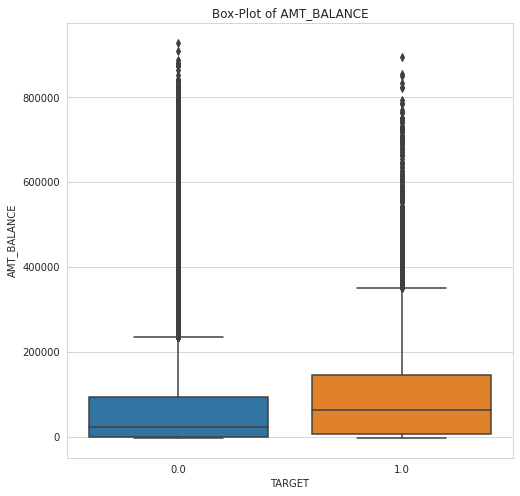

In [ ]:
plot_continuous_variables(credit_card_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

**Comment**
1.   From the above plot, it can be seen that the Defaulters have a higher value of AMT_BALANCE as compared to Non-Defaulters. They show a higher values of all the quantiles and even the whiskers. This could imply that the Credit amount for Defaulters could also be relatively higher as compared to Non-Defaulters.
2.   We see that the Defaulters here too appeared to have a higher minimum installment each month as compared to Non-Defaulters. This usually tells about the spending and borrowing habbit of the people. The defaulters show a higher spending and borrowing habits as compared to Non-Defaulters.




### **AMT_TOTAL_RECEIVABLE**

This column describes the average of total amount receivable on the previous credit.


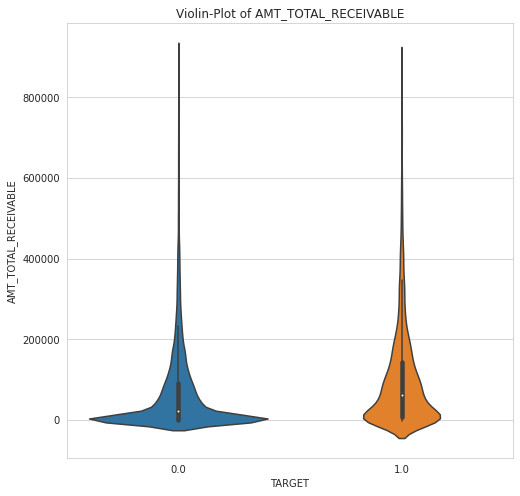

In [ ]:
plot_continuous_variables(credit_card_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

**Comment**

Looking at the box plot of AMT_TOTAL_RECEIVABLE, we see a similar behavious as seen with other amounts as well, which is that the Defaulters usually had higher Amount Receivable on their previous credit, which may imply the higher amounts of credits that they may have taken. The PDF also shows a very higher peak at lower amounts for Non-Defaulters as compared to Defaulters.

### **CNT_INSTALMENT_MATURE_CUM**

The column describes about the average number of installments paid on the previous credits.


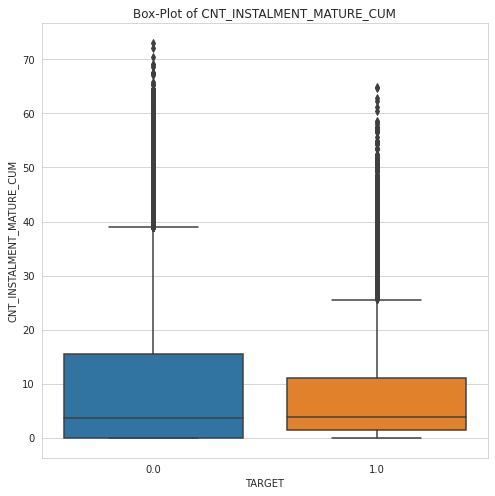

In [ ]:
plot_continuous_variables(credit_card_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

**Comment**

From the above plot, we see a very interesting behaviour. This plot shows that the Non-Defaulters usually had higher range of values for the number of installments paid as compared to Defaulters. This might show the defaulting behaviour, where in the defaulters usually would pay fewer number of installments on their previous credit.

### **Months_Balance**

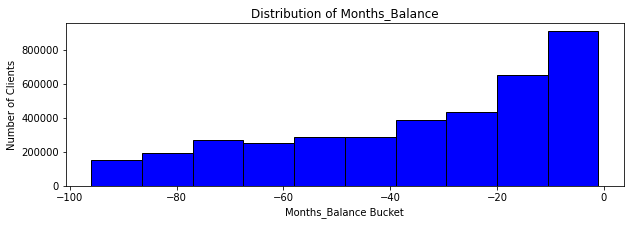

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Months_Balance')
plt.xlabel('Months_Balance Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Comment** : *Most of the clients have Months_Balance between 0-10 months before the application date.*

### **Cnt_Drawings_Current**

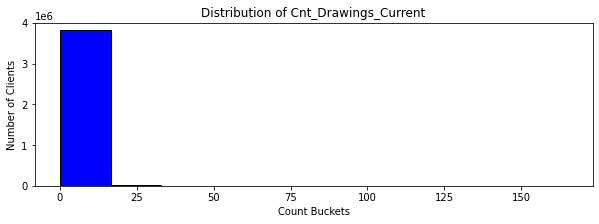

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['CNT_DRAWINGS_CURRENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Cnt_Drawings_Current')
plt.xlabel('Count Buckets')
plt.ylabel('Number of Clients')
plt.show()

**Comment :** *The vast majority of the clients have less than 25 months of drawing in the current month on the previous credit, except a very small number of outliers.*